In [1]:
import torch
import torchvision
import os
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import tqdm
from torch import nn
import torch.nn.functional as F
from skimage import transform
from torch.autograd import Variable
import logging
import pickle
from PIL import ImageFilter
from IPython import display
import crop
from scipy.signal import fftconvolve

In [2]:
def load_ims(fnames, addr='../img_align_celeba/'):
    ims = []
    for fname in fnames:
        ims.append(io.imread(addr + fname))
    return np.stack(ims)

def get_filename(idx, folder='../img_align_celeba/'):
    idstr = str(idx)
    fid = ''.join(['0'] * (6 - len(idstr)) + [idstr])
    return ''.join([folder, fid, '.jpg'])

def test_transform(X):
    height = X.shape[1]
    width = X.shape[2]
    X_out = np.zeros((X.shape[0], height, width, 3), dtype=np.float32)
    for idx, x in enumerate(X):
        x = transform.resize(x, (height, width))
        X_out[idx] = x
    X_out = X_out.transpose([0, 3, 1, 2])
    return X_out

def get_cosine_scores(sample, embeddings):
    samplen = np.sqrt((sample ** 2).sum())
    embn = np.sqrt((embeddings ** 2).sum(axis=1))
    return 1 - embeddings.dot(sample) / (embn * samplen)

def get_euclidean_scores(sample, embeddings):
    return np.sqrt(((embeddings - sample) ** 2).sum(axis=1))

In [3]:
class MyVGG(nn.Module):
    
    def __init__(self):
        super(MyVGG, self).__init__()
        self.features = torchvision.models.squeezenet1_0(pretrained=False).features
        #for par in self.features.parameters():
        #    par.requires_grad=False
        #15360
        #66560
        self.embeddings = nn.Sequential(nn.Linear(66560, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
                                        # nn.Linear(4096, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
                                        nn.Linear(1024, 128))
        self.classif = nn.Sequential(self.embeddings, nn.ReLU(), nn.Linear(128, 40))
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        # print(x.shape)
        return F.sigmoid(self.classif(x))
    
    def get_embeddings(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.embeddings(x)
 
        return F.normalize(x, dim=1)

In [4]:
net = MyVGG()
net.load_state_dict(torch.load('model_tune1'))
net = net.eval()
net = net.cuda()

In [5]:
embeddings = pickle.load(open('embeddings_tune', 'rb'))

269.85 779.3 40.45842696629214 664.3915730337078


/home/vch/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


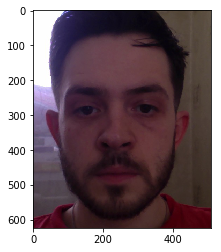

In [6]:
im_my = io.imread('../1.jpg')
im_my = crop.crop_face(im_my, (218, 178))
plt.imshow(im_my)
#im_my = im_my[:, 200:800]
im_my = transform.resize(im_my, (218, 178))
im_my = test_transform(im_my[None])
my_var = Variable(torch.FloatTensor(im_my).cuda(), requires_grad=True)
my_emb = net.get_embeddings(my_var)

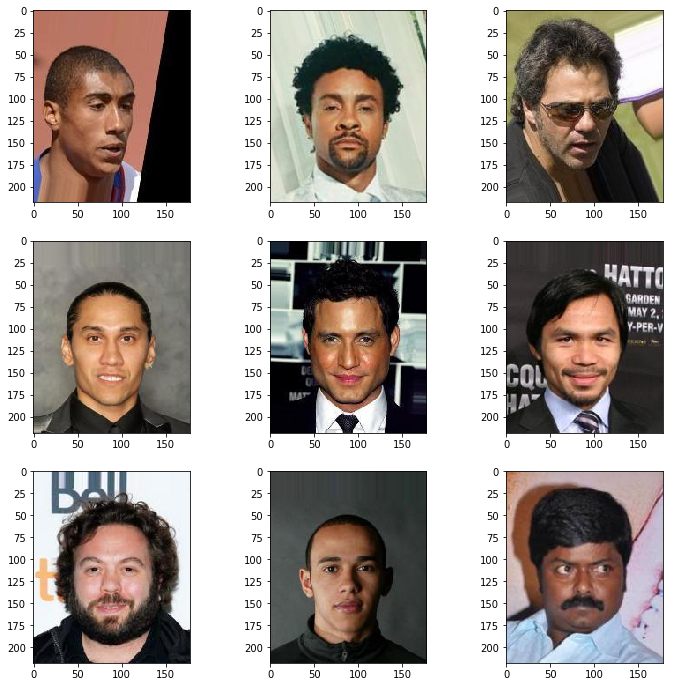

In [7]:
scores = get_cosine_scores(my_emb[0].data.cpu().numpy(), embeddings)
args = np.argsort(scores)
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        ax[j][i].imshow(io.imread(get_filename(args[j * 3 + i] + 1)))

In [28]:
args

array([193499, 141785,  49248, ...,  53087,  52803,   6484])

In [29]:
closeim = io.imread(get_filename(77044))
closeim = test_transform(closeim[None])
closevar = Variable(torch.FloatTensor(closeim).cuda())
close_emb = net.get_embeddings(closevar)

/home/vch/py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [30]:
target = Variable(0.5 * (my_emb.data + close_emb.data))

In [31]:
def recover(im):
    im = im[0].transpose([1, 2, 0])
    return (im - im.min()) / (im.max() - im.min())

def transf(im):
    return test_transform(im[None])

In [32]:
optimizer = torch.optim.Adam((my_var,), lr=0.0001)
criterion = F.mse_loss

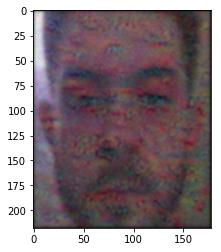

KeyboardInterrupt: 

In [33]:
for epoch in range(10):
    for _ in range(500):
        emb = net.get_embeddings(my_var)
        loss = criterion(emb, target)
        # print(loss.data.cpu().numpy())
        loss.backward()
        optimizer.step()
    im = recover(my_var.cpu().data.numpy())
    im = fftconvolve(im, np.array([[[0.1], [0.1], [0.1]],
                                   [[0.1], [0.2], [0.1]],
                                   [[0.1], [0.1], [0.1]]]), mode='same')
    my_var = Variable(torch.FloatTensor(transf(im)).cuda(), requires_grad=True)
    optimizer = torch.optim.Adam((my_var,), lr=0.0001)
    display.clear_output(wait=True)
    plt.imshow(im)
    plt.show()

In [ ]:
im = recover(my_var.cpu().data.numpy())

In [ ]:
plt.imshow(ImageFilter.GaussianBlur() im)

In [61]:
from scipy.signal import fftconvolve

In [73]:
im1 = fftconvolve(im1, np.array([[[0.25], [0.25]], [[0.25], [0.25]]]))

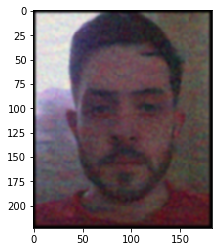

In [74]:
plt.imshow(im1)

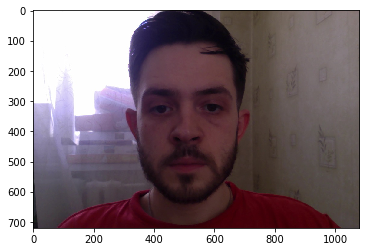

In [56]:
im_my = io.imread('../1.jpg')
plt.imshow(im_my)

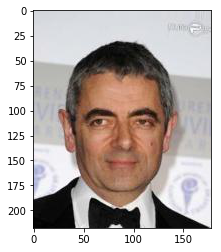

In [14]:
plt.imshow(recover(closeim))